100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [01:28<00:00, 1928137.97it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:10<00:00, 4.62MB/s]


Epoch 1 finished, loss: 0.220, accuracy: 0.917
Epoch 2 finished, loss: 0.065, accuracy: 0.976
Epoch 3 finished, loss: 0.038, accuracy: 0.986
Epoch 4 finished, loss: 0.031, accuracy: 0.990
Epoch 5 finished, loss: 0.020, accuracy: 0.994
Epoch 6 finished, loss: 0.020, accuracy: 0.993
Epoch 7 finished, loss: 0.010, accuracy: 0.997
Epoch 8 finished, loss: 0.006, accuracy: 0.998
Epoch 9 finished, loss: 0.008, accuracy: 0.997
Epoch 10 finished, loss: 0.014, accuracy: 0.995
Finished Training


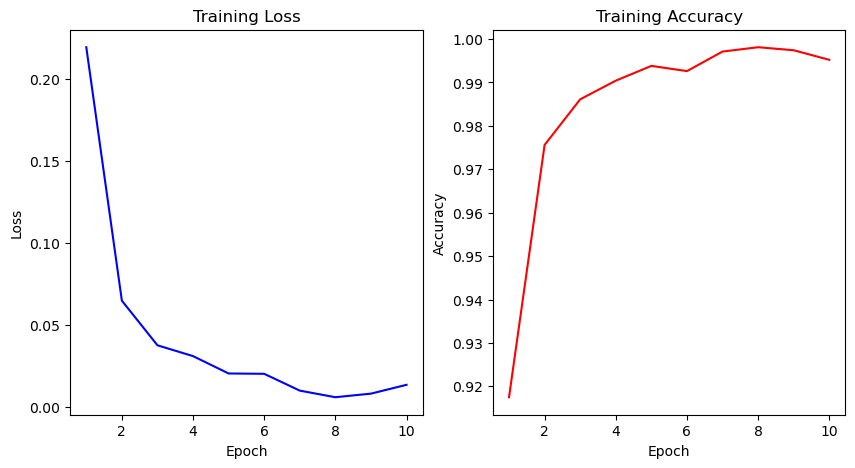

Accuracy of the network on the test images: 96 %


In [1]:
# Import the necessary modules
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.01

# Load the CIFAR10 dataset and select only the airplane and car classes
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset.targets = torch.tensor(trainset.targets)
trainset.data = trainset.data[trainset.targets <= 1]
trainset.targets = trainset.targets[trainset.targets <= 1]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset.targets = torch.tensor(testset.targets)
testset.data = testset.data[testset.targets <= 1]
testset.targets = testset.targets[testset.targets <= 1]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('airplane', 'car')

# Define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained convolutional network and modify the last fully connected layer
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Train the model
train_loss = []
train_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = running_correct / len(trainset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    print('Epoch %d finished, loss: %.3f, accuracy: %.3f' % (epoch + 1, epoch_loss, epoch_acc))

print('Finished Training')

# Plot the accuracy and loss graph for different epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Calculate the accuracy of the trained model on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
